In [1]:
#load the required libraries
suppressMessages(suppressWarnings({library(dplyr)
library(vsn)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
library(openxlsx)
library(VennDiagram)
library(DESeq2)
library(ggplotify)
library(gridExtra)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(EnhancedVolcano)
library(gridExtra)
library(pheatmap)
library(clusterProfiler)
library(ggpubr)
library(RColorBrewer)}))

In [11]:
# Set output directory
current_date <- format(Sys.Date(), "%Y%m%d")
DESeq2_Output_Dir <- paste0(current_date, "_DE_Results")
ifelse(dir.exists(DESeq2_Output_Dir), NA, dir.create(DESeq2_Output_Dir))

gene_lists <- "gene_lists"
ifelse(dir.exists(gene_lists), NA, dir.create(gene_lists))

#write the rnaseq_metrics.txt to xlsx format in the outdir
write.xlsx(read.table("rnaseq_metrics.txt", header = T, sep = "\t"), file = file.path(DESeq2_Output_Dir, "rnaseq_metrics.xlsx"))

[1] NA

[1] NA

In [3]:
# Load sample information
sample_info <- read.delim("sample_info.txt")
# load counts
countData <- read.csv("DESeq2/gene_count_matrix.csv", row.names = 1)
# Load contrasts
contrasts <- read.delim("contrasts.txt")

In [4]:
colData <- sample_info
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ sampleCondition)
dds <- DESeq(dds)
vsd <- vst(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [5]:
#use metadata file for the organism
GTFinfo <- read.delim(file = "/home/at2253/soft/DESeq2/hg38_gencode_v27_GTF_info_details.txt", header = TRUE)
GTFinfo <- GTFinfo[match(rownames(dds), GTFinfo$GeneVer),]
all(rownames(dds) == GTFinfo$GeneVer)
rownames(GTFinfo) <- GTFinfo$GeneVer
mcols(dds) <- DataFrame(mcols(dds), GTFinfo)

[1] TRUE

In [6]:
# Extract raw and normalized counts
raw_counts <- as.data.frame(counts(dds, normalized = FALSE))
normalized_counts <- as.data.frame(counts(dds, normalized = TRUE))

# Add gene_id as a column for merging
raw_counts$GeneVer <- rownames(raw_counts)
normalized_counts$GeneVer<- rownames(normalized_counts)

# Merge with GTFinfo by gene_id
raw_with_gtf <- merge(GTFinfo, raw_counts, by = "GeneVer")
norm_with_gtf <- merge(GTFinfo, normalized_counts, by = "GeneVer")

# Write to CSV
write.csv(raw_with_gtf, file = paste(DESeq2_Output_Dir, "gene_counts_raw.csv", sep = "/"), row.names = FALSE)
write.csv(norm_with_gtf, file = paste(DESeq2_Output_Dir, "gene_counts_normalized.csv", sep = "/"), row.names = FALSE)



pdf 
  2

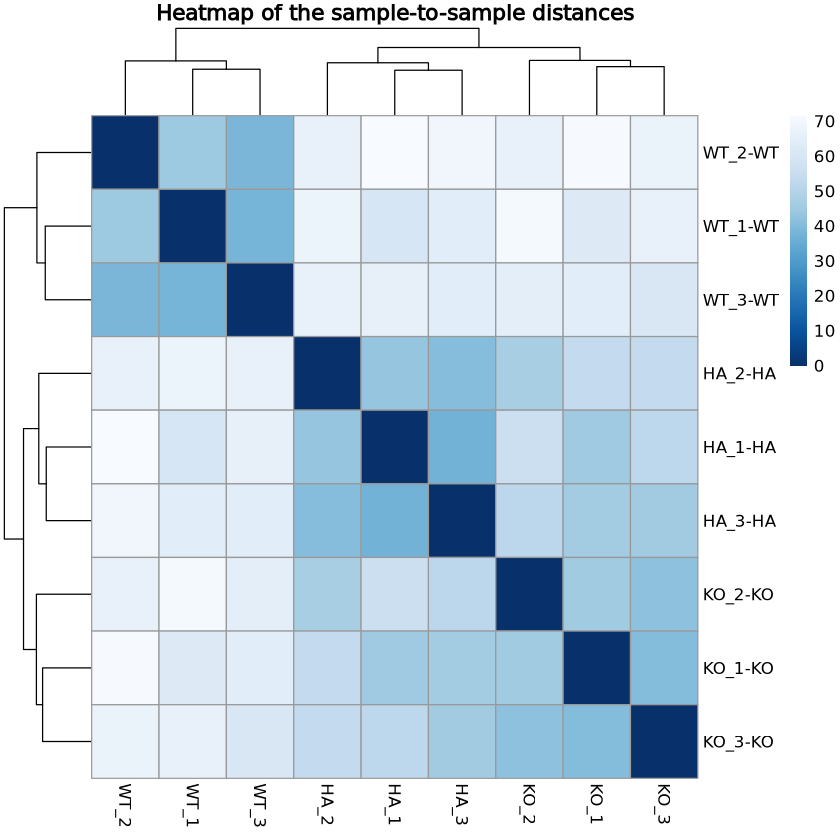

In [7]:
# Perform PCA
pca <- prcomp(t(assay(vsd)))
pcaData <- as.data.frame(pca$x)
pcaData$sampleCondition <- colData$sampleCondition

# Calculate variance
variance <- summary(pca)$importance["Proportion of Variance", ] * 100
variance_df <- data.frame(PC = factor(1:5), Variance = variance[1:5])

# Calculate percent variance for labels
percentVar <- variance[1:3]

# Bar plot of variance
barplot_gg <- ggplot(variance_df, aes(x = PC, y = Variance)) +
  geom_bar(stat = "identity") +
  labs(x = "Principal Component", y = "Proportion of Variance (%)", title = "PCA Proportion of Variance") +
  theme_minimal()

# PC1 vs PC2
pca_plot1 <- ggplot(pcaData, aes(x = PC1, y = PC2)) +
    geom_point(aes(col = sampleCondition), size = 2) +
    xlab(paste0("PC1: ", round(percentVar[1], 2), "%")) +
    ylab(paste0("PC2: ", round(percentVar[2], 2), "%")) +
    theme_bw()

# PC1 vs PC3
pca_plot2 <- ggplot(pcaData, aes(x = PC1, y = PC3)) +
    geom_point(aes(col = sampleCondition), size = 2) +
    xlab(paste0("PC1: ", round(percentVar[1], 2), "%")) +
    ylab(paste0("PC3: ", round(percentVar[3], 2), "%")) +
    theme_bw()

# PC2 vs PC3
pca_plot3 <- ggplot(pcaData, aes(x = PC2, y = PC3)) +
    geom_point(aes(col = sampleCondition), size = 2) +
    xlab(paste0("PC2: ", round(percentVar[2], 2), "%")) +
    ylab(paste0("PC3: ", round(percentVar[3], 2), "%")) +
    theme_bw()

# Initialize Heatmap of the sample-to-sample distances
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$sample, vsd$sampleCondition, sep="-")
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

dist_heatmap <- pheatmap(sampleDistMatrix, 
                         clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists,col=colors, 
                         main = "Heatmap of the sample-to-sample distances")

# Save plots to PDF
pdf(paste(DESeq2_Output_Dir, "sample_Distances_and_PCA_plots.pdf", sep = "/"), width = 8, height = 7)
print(dist_heatmap)
print(barplot_gg)
print(pca_plot1)
print(pca_plot2)
print(pca_plot3)
dev.off()

In [8]:
# Calculate normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Open a PDF device for volcano plots
pdf(file.path(DESeq2_Output_Dir, "Volcano_and_MA_plots_allComparisons.pdf"), width = 8, height = 10)

# Initialize workbooks
wb_all <- createWorkbook()
wb_sig <- createWorkbook()

# Initialize a data frame to store the summary of significant gene counts
summary_df <- data.frame(contrast = character(), gene_count_up = integer(), gene_count_down = integer(), 
                         gene_count_upFC2 = integer(), gene_count_downFC2 = integer(),
                         gene_count_upFC2p01 = integer(), gene_count_downFC2p01 = integer(),
                         stringsAsFactors = FALSE)


# Loop through each contrast pair
for (i in 1:nrow(contrasts)) {
  contrast <- as.character(contrasts[i, ])
  res <- results(dds, contrast = c("sampleCondition", contrast[1], contrast[2]))
  
  # Convert results to data frame and merge with GTFinfo
  res_df <- as.data.frame(res)
  res_df <- merge(res_df, GTFinfo, by.x = "row.names", by.y = "GeneVer", all.x = TRUE)
  rownames(res_df) <- res_df$Row.names
  res_df$Row.names <- NULL
  
  # Filter for significant genes and exclude NA values in padj
  sig_res_df <- res_df[!is.na(res_df$padj) & res_df$padj <= 0.05, ]
  sig_res_dfFC2 <- res_df[!is.na(res_df$padj) & res_df$padj <= 0.05 & abs(res_df$log2FoldChange) > 2, ]
  
  # Sort significant results by log2FoldChange from highest to lowest
  sig_res_df <- sig_res_df[order(sig_res_df$log2FoldChange, decreasing = TRUE), ]
  
  # Count the number of up- and down-regulated significant genes
  gene_count_up <- sum(sig_res_df$log2FoldChange > 0)
  gene_count_down <- sum(sig_res_df$log2FoldChange < 0)
  gene_count_upFC2 <- sum(sig_res_df$log2FoldChange > 2)
  gene_count_downFC2 <- sum(sig_res_df$log2FoldChange < -2)
  gene_count_upFC2p01 <- sum(sig_res_df$log2FoldChange > 2 & sig_res_df$padj <= 0.01)
  gene_count_downFC2p01 <- sum(sig_res_df$log2FoldChange < -2 & sig_res_df$padj <= 0.01)
  
  # Add the counts to the summary data frame
  summary_df <- rbind(summary_df, data.frame(contrast = paste(contrast[1], "vs", contrast[2]), 
                                             gene_count_up,  gene_count_down,
                                             gene_count_upFC2, gene_count_downFC2,
                                             gene_count_upFC2p01, gene_count_downFC2p01))
    
  # Extract significant gene names
  sig_genes <- sig_res_df$GeneName
  
  # Write significant genes to a text file for Enrichr
  sig_genes_file <- file.path(gene_lists, paste0("gene_list", contrast[1], "_vs_", contrast[2], ".padj05.txt"))
  write.table(na.omit(sig_res_df$ENTREZID), file = sig_genes_file, quote = FALSE, row.names = FALSE, col.names = FALSE)

  # Write FC2 significant genes to a text file for Enrichr
  sig_genesFC2_file <- file.path(gene_lists, paste0("gene_list", contrast[1], "_vs_", contrast[2], ".padj05FC2.txt"))
  write.table(na.omit(sig_res_dfFC2$ENTREZID), file = sig_genesFC2_file, quote = FALSE, row.names = FALSE, col.names = FALSE)
    
  # Define sheet name
  sheet_name <- paste(contrast[1], "vs", contrast[2])

  # Add sheets and write data to respective workbooks
  addWorksheet(wb_all, sheet_name)
  res_df_out <- cbind(GeneVer = rownames(res_df), res_df)
  writeData(wb_all, sheet_name, res_df_out, startRow = 1, startCol = 1)

  addWorksheet(wb_sig, sheet_name)
  sig_res_df_out <- cbind(GeneVer = rownames(sig_res_df), sig_res_df)
  writeData(wb_sig, sheet_name, sig_res_df_out, startRow = 1, startCol = 1)

  # Highlight top 10 up- and down-regulated genes
  top_up <- res_df[order(res_df$log2FoldChange, decreasing = TRUE), ][1:10, ]
  top_down <- res_df[order(res_df$log2FoldChange), ][1:10, ]
  top_genes <- rbind(top_up, top_down)

  # Create volcano plot using EnhancedVolcano
  p <- EnhancedVolcano(res_df,
                       lab = res_df$GeneSymbol,
                       x = 'log2FoldChange',
                       y = 'padj',
                       selectLab = top_genes$GeneSymbol,
                       title = paste("Volcano Plot:", contrast[1], "vs", contrast[2]),
                       pCutoff = 0.05,
                       FCcutoff = 1.5,
                       pointSize = 1.0,
                       labSize = 3.0,
                       colAlpha = 0.5,
                       legendLabels = c('NS', 'Log2 FC', 'P', 'P & Log2 FC'),
                       legendPosition = 'right',
                       legendLabSize = 12,
                       legendIconSize = 4.0)
      
  # Print the plot to the PDF device
  print(p)
  ma_plot <- ggmaplot(res_df,
                       fdr = 0.05,
                       genenames = res_df$GeneSymbol,
                       fc = 1,
                       size = 0.8,
                       main = paste("MA plot:", contrast[1], "vs", contrast[2]),
                       legend = "top", top = 20,
                       ggtheme = ggplot2::theme_minimal())
  print(ma_plot)
}

# Close the PDF device
dev.off()

# Save the workbooks
saveWorkbook(wb_all, file.path(DESeq2_Output_Dir, "DESeq2_AllGenes.xlsx"), overwrite = TRUE)
saveWorkbook(wb_sig, file.path(DESeq2_Output_Dir, "DESeq2_SignificantGenes.xlsx"), overwrite = TRUE)

# Write the summary of significant gene counts to a CSV file
summary_file <- file.path(DESeq2_Output_Dir, "significant_gene_counts_summary.csv")
write.csv(summary_df, file = summary_file, row.names = FALSE)
summary_df

Warning message:
“Removed 24156 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 24156 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 24156 rows containing missing values or values outside the scale range
(`geom_point()`).”


pdf 
  2

contrast,gene_count_up,gene_count_down,gene_count_upFC2,gene_count_downFC2,gene_count_upFC2p01,gene_count_downFC2p01
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
HA vs KO,746,1007,31,78,23,58
WT vs HA,3435,3114,389,221,294,157
WT vs KO,3120,2920,315,269,220,186


In [9]:
# Directory containing gene list files
#gene_lists <- "gene_lists"

# List all relevant files to be decided based on the DE gene count from summary_df
files <- list.files(gene_lists, pattern = "gene_list.*_vs_.*\\.padj05\\.txt$", full.names = TRUE)

# Create a new workbook
wb <- createWorkbook()

for (file in files) {
  # Extract contrast from filename
  filename <- basename(file)
  contrast <- sub("gene_list(.*)_vs_(.*)\\.padj05\\.txt", "\\1_vs_\\2", filename)
  
  # Read gene list
  gene_list <- scan(file, what = "", quiet = TRUE)
  
  # Run KEGG enrichment # Replace with correct KEGG organism code available from https://www.genome.jp/kegg/tables/br08606.html
  kk <- enrichKEGG(
    gene     = gene_list,
    organism = "hsa", pvalueCutoff = 0.05
  )
  
  # Convert to data frame
  kk_df <- as.data.frame(kk)
  
  # Add worksheet and write data
  addWorksheet(wb, sheetName = contrast)
  writeData(wb, sheet = contrast, x = kk_df)
  
  cat("Added sheet for:", contrast, "\n")
}

# Save workbook
saveWorkbook(wb, file = file.path(DESeq2_Output_Dir, "KEGG_enrichment_results.xlsx"), overwrite = TRUE)



Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



Added sheet for: HA_vs_KO 
Added sheet for: WT_vs_HA 
Added sheet for: WT_vs_KO 


In [10]:
# Save sessionInfo() to a text file
capture.output(sessionInfo(), file = file.path(DESeq2_Output_Dir, "session_info.txt"))

In [19]:
norm = na.omit

na.fail {stats},R Documentation
object,"an R object, typically a data frame"
...,further arguments special methods could require.


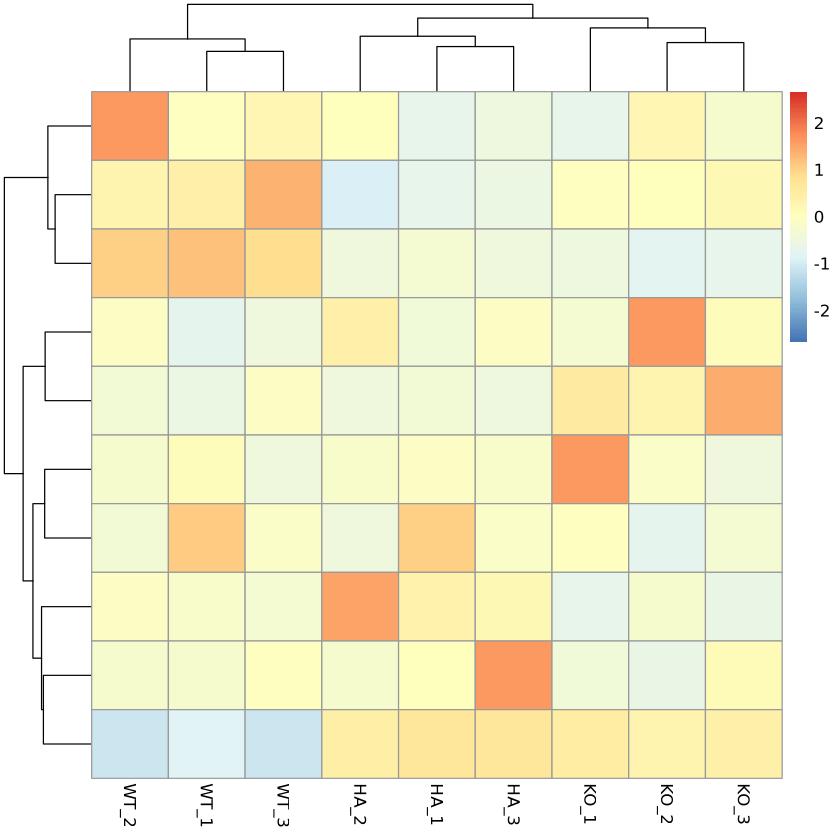

In [31]:
pheatmap(vst_clean, scale = "row",show_rownames = F, kmeans_k = 10)

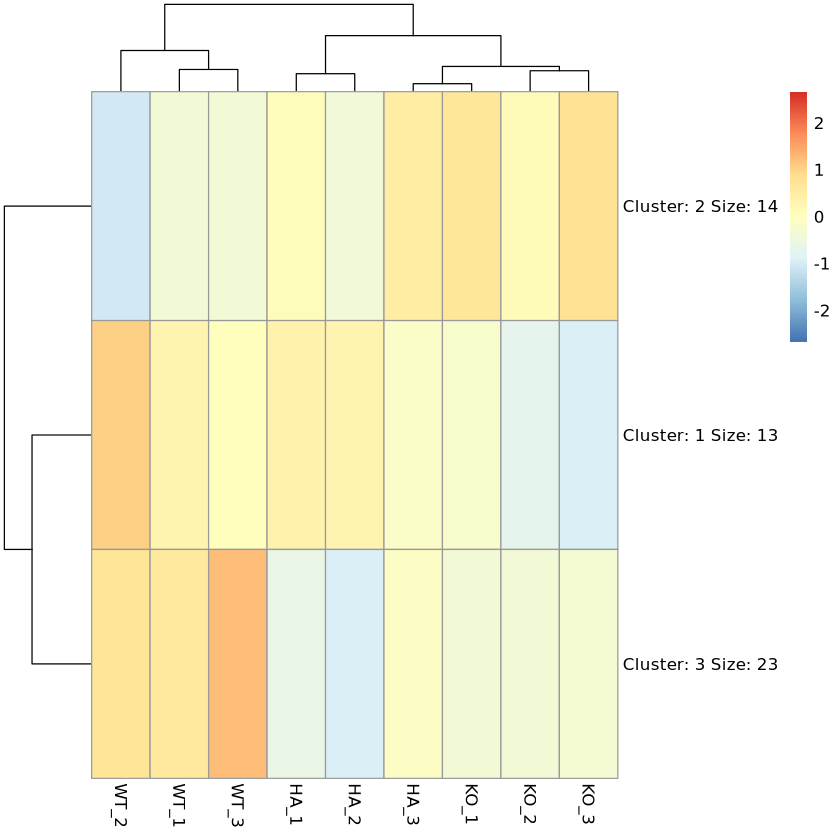

In [32]:
pheatmap(vst_clean[1:50, ], scale = "row", show_rownames = TRUE, kmeans_k = 3)


In [22]:


vst_clean <- vst_mat[apply(vst_mat, 1, function(x) sd(x) > 0), ]


In [33]:
vst_clean

,HA_1,HA_2,HA_3,KO_1,KO_2,KO_3,WT_1,WT_2,WT_3
ENSG00000238009.6,6.228279,6.228279,6.228279,6.228279,6.525731,6.228279,6.228279,6.228279,6.528759
ENSG00000268903.1,6.228279,6.228279,6.228279,6.228279,6.228279,6.228279,6.228279,6.392424,6.228279
ENSG00000269981.1,6.228279,6.228279,6.443338,6.228279,6.571545,6.468668,6.228279,6.512281,6.528759
ENSG00000241860.6,6.718249,6.516605,6.752661,6.790957,7.042497,6.736186,6.637105,6.556040,6.528759
ENSG00000236679.2,6.228279,6.228279,6.491550,6.228279,6.400215,6.522525,6.228279,6.228279,6.228279
ENSG00000237094.12,7.755505,7.800051,7.639238,7.816983,7.924935,7.814554,7.476806,7.281674,7.724485
ENSG00000230021.9,6.392300,6.561026,6.851014,6.790957,6.571545,6.468668,6.383244,6.937008,6.957835
ENSG00000278791.1,6.228279,6.394929,6.380419,6.407228,6.400215,6.398358,6.228279,6.392424,6.401970
ENSG00000228327.3,8.075605,8.129793,7.884576,8.368211,7.910863,8.100483,8.607663,8.278993,8.462281
ENSG00000237491.8,7.257150,7.235565,7.446889,7.479908,7.226066,7.342005,7.424320,7.392102,7.598749
